Goal: We will be using a dataset containing information from a **bicycle rental company** called capital bikeshare which is located in Washington D.C. The aim is to develop a model that can predict bicycle usage at a given day.

In [644]:
# Main libraries
import pandas as pd
import numpy as np
import os
import datetime as dt

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import dates as mpl_dates
import matplotlib.colors as mc
%matplotlib inline

# Splitting data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
#PCA
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit 

import warnings
warnings.filterwarnings("ignore")


### 1. Get and Prepare the data

Capital Bikeshare provides their data publically available at their [site](https://www.capitalbikeshare.com/system-data). We can obtain data of each ride per day from 2010 up to 2020. Since the objective of this project is to predict the amount of bikes that will be rented at a given date, we need to generate from that data a sigle file containing the amount of bikes and bike-time rented each day. Futhermore, it would be useful to have some parameters of the weather data from each day to make our predictions.

1.1 First, lets combine all the csv files downloaded individually from their site.

In [4]:
os.chdir(r"C:\Users\enriq\Your_env_name_Notebooks\Git_hub BikeCompany\data_bikeshare") # Setting the working directory

In [3]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*')]

In [4]:
all_filenames

['combined_csv3.csv', 'combined_csv5.csv']

In [5]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "all_data_combined.csv", index=False, encoding='utf-8-sig') 

C:\Users\enriq\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1,2,4,6,7,8,9,10,11,12,13,15,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


1.2 Second I will simplify the data and extract only the information needed for this project. We need to read the file in chunks due to its large size (this file has around 27 million rows- 3.8 gb)

In [9]:
mylist = []

for chunk in pd.read_csv("all_data_combined.csv", dtype = {"Duration":str,"Start date": str,
                                                "Bike number": str, "Member type": str}, low_memory=False, 
               usecols = ["Duration","Start date","Bike number","Member type"], error_bad_lines = False, chunksize=20000): # specifying the type str and columns to save memory usage
                mylist.append(chunk)
df = pd.concat(mylist, axis= 0)
del mylist

In [12]:
df.dropna(inplace=True)

In [18]:
df.head()

,Duration,Start date,Bike number,Member type
0,1716.0,2014-01-01 00:06:03,W01363,Member
1,154.0,2014-01-01 00:11:09,W01433,Member
2,318.0,2014-01-01 00:12:19,W00065,Member
3,480.0,2014-01-01 00:14:02,W20903,Member
4,345.0,2014-01-01 00:15:33,W20888,Member


In [17]:
df["Duration"] = df["Duration"].astype(float)

In [19]:
df["Start date"] = pd.to_datetime(df["Start date"], format="%Y-%m-%d %H:%M:%S") # changing to dt type

In [20]:
df["Start date"] = df["Start date"].dt.strftime("%d-%m-%Y") # changing the format(back to str)

In [21]:
df["Member"] = df["Member type"].apply(lambda x: 1 if x == "Member" else 0)

In [23]:
# Lets generate the information for each day using pivot tables
df_1 = pd.pivot_table(df, index=["Start date"], values = ["Duration"], aggfunc = ["sum"]) # total usage time
df_2 = pd.pivot_table(df, index=["Start date"], values = ["Bike number"], aggfunc = ["count"]) # total bikes used
df_3 = pd.pivot_table(df, index=["Start date"], values = ["Member"], aggfunc = ["mean"]) # proportion of members
df = pd.concat((df_1, df_2, df_3), axis=1)

In [24]:
df.columns = ["Total bicicle usage(seconds)", "Number of bikes", "Proportion members"]

In [26]:
df["Usage per bike(seconds)"] = round(df["Total bicicle usage(seconds)"]/df["Number of bikes"])

In [29]:
df.to_csv("daily_bike_data.csv", index=True)

In [475]:
df=pd.read_csv("daily_bike_data.csv")

In [476]:
df["Start date"] = pd.to_datetime(df["Start date"], format="%d-%m-%Y")

In [477]:
df["Week day"] = df["Start date"].dt.day_name()

In [478]:
df = df.sort_values(by="Start date") # ordering by ascending date

In [479]:
df = df.reset_index().drop("index", axis=1)

In [480]:
df

,Start date,Total bicicle usage(seconds),Number of bikes,Proportion members,Usage per bike(seconds),Week day
0,2010-09-20,242253.0,212,0.839623,1143.0,Monday
1,2010-09-21,414304.0,324,0.663580,1279.0,Tuesday
2,2010-09-22,600602.0,377,0.689655,1593.0,Wednesday
3,2010-09-23,650596.0,373,0.667560,1744.0,Thursday
4,2010-09-24,704149.0,362,0.569061,1945.0,Friday
...,...,...,...,...,...,...
3472,2020-03-27,5006927.0,3192,0.874060,1569.0,Friday
3473,2020-03-28,3303571.0,2293,0.888792,1441.0,Saturday
3474,2020-03-29,7632360.0,4171,0.832654,1830.0,Sunday
3475,2020-03-30,4185924.0,2901,0.897277,1443.0,Monday


1.3 Next we will get the weather data. Historical daily rain and temperature data for washington area was obtained from [Cargenie Mellon University](https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488).
City Weather Stations IDs can use found [here](https://docs.opendata.aws/noaa-ghcn-pds/readme.html).

In [481]:
weather_data = pd.read_csv("weather_data_washington.csv")

In [482]:
weather_data.drop("Unnamed: 0", axis=1, inplace=True) # drop preexisting index

In [483]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"], format="%Y-%m-%d") # dates to datetime format

In [484]:
weather_data = weather_data.loc[weather_data["Date"]>= df["Start date"].min()] # weonly need data from 2011

In [485]:
weather_data = weather_data.reset_index().drop("index", axis=1)

In [486]:
weather_data["t max"] = round((weather_data["tmax"] -32)*5/9,1) #trasnform farenheit to celcius

In [487]:
weather_data["t min"] = round((weather_data["tmin"] -32)*5/9,1) 

In [488]:
weather_data = weather_data.drop(["tmax","tmin"], axis=1) # remove farenheit degrees

In [489]:
df.rename({"Start date": "Date"}, axis=1, inplace=True)

In [490]:
df = pd.merge(df, weather_data, on="Date", how="left") # merge both dfs on the common column date

In [491]:
df.dropna(inplace=True) # we did not have all weather days for few records

In [492]:
df["average Temp"] = (df["t max"] + df["t min"])/2

In [493]:
df["Date"]

0      2010-09-20
1      2010-09-21
2      2010-09-22
3      2010-09-23
4      2010-09-24
          ...    
3381   2019-12-27
3382   2019-12-28
3383   2019-12-29
3384   2019-12-30
3385   2019-12-31
Name: Date, Length: 3380, dtype: datetime64[ns]

Next I will add US holidays to enrich our analyses

In [494]:
holidays=pd.read_csv("usholidays.csv")

In [495]:
holidays.drop("Unnamed: 0", axis=1, inplace=True)

In [496]:
holidays["Date"] =  pd.to_datetime(holidays["Date"], format="%Y-%m-%d")

In [497]:
holidays

,Date,Holiday
0,2010-12-31,New Year's Day
1,2011-01-17,"Birthday of Martin Luther King, Jr."
2,2011-02-21,Washington's Birthday
3,2011-05-30,Memorial Day
4,2011-07-04,Independence Day
...,...,...
480,1966-09-05,Labor Day
481,1966-10-12,Columbus Day
482,1966-11-11,Veterans Day
483,1966-11-24,Thanksgiving Day


In [498]:
holidays = holidays.loc[holidays["Date"]>= df["Date"].min()]

In [499]:
df = pd.merge(df, holidays, on="Date", how="left") 

In [500]:
df["Holiday"] = df["Holiday"].apply(lambda x: 0 if (pd.isna(x) == True) else 1)

In [501]:
Weekend_holiday = []
for i in range(len(df["Holiday"])):
    if (df["Week day"][i] in ["Saturday","Sunday"]) | ((df["Holiday"][i] == 1)):
        Weekend_holiday.append(1)
    else:
        Weekend_holiday.append(0)

In [502]:
Weekend_holiday = pd.Series(Weekend_holiday)

In [503]:
df["Holiday/Weekend"] = Weekend_holiday 

In [504]:
df["Year"] = df["Date"].dt.year # generating a year column
df["Month"] = df["Date"].dt.month # generating month column
df["Week"] = df["Date"].dt.week
df["Day"] = df["Date"].dt.day # generating day column

In [505]:
df.rename({"Number of bikes": "Number of trips"}, axis=1, inplace=True) # More clear name

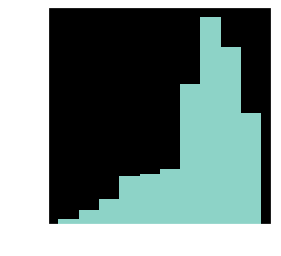

In [506]:
plt.rcParams["figure.figsize"] = (4,4)
plt.hist(df["Proportion members"])
plt.show()

In [507]:
def membership_level(item):
    if item < 0.7:
        return "low"
    if item >= 0.7 and item <= 0.8:
        return "medium"
    if item > 0.8:
        return "high"

In [508]:
df["membership"] = df["Proportion members"].apply(membership_level)

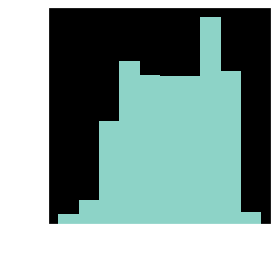

In [509]:
plt.hist(df["average Temp"])
plt.show()

In [510]:
def temperature_level(item):
    if item < 0:
        return "freezing"
    if item > 0 and item <= 15:
        return "cold"
    if item > 15:
        return "nice"

In [511]:
df["Temp Level"] = df["average Temp"].apply(temperature_level)

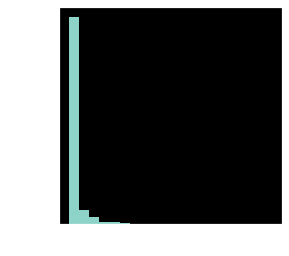

In [512]:
plt.hist(df["prcp"], bins=20)
plt.show()

In [513]:
def rain_level(item):
    if item <= 0:
        return "dry"
    if item > 0 and item < 1:
        return "light"
    if item >= 1:
        return "heavy"

In [514]:
df["Rain Level"] = df["prcp"].apply(rain_level)

In [515]:
def date_to_nth_day(date, format='%Y-%m-%d'):
    date = pd.to_datetime(date, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1

In [516]:
df["Day of year"] = df["Date"].apply(date_to_nth_day)

In [517]:
spring = range(80, 172)
summer = range(172, 264)
autumn = range(264, 355)

def season(item):
    if item in spring:
          return 'spring'
    elif item in summer:
          return 'summer'
    elif item in autumn:
          return 'autumn'
    else:
          return 'winter'

In [518]:
 df["Season"] = df["Day of year"].apply(season)

In [519]:
df.head() # data is ready for further analyses

,Date,Total bicicle usage(seconds),Number of trips,Proportion members,Usage per bike(seconds),Week day,prcp,t max,t min,average Temp,...,Holiday/Weekend,Year,Month,Week,Day,membership,Temp Level,Rain Level,Day of year,Season
0,2010-09-20,242253.0,212,0.839623,1143.0,Monday,0.0,25.6,12.8,19.20,...,0,2010,9,38,20,high,nice,dry,263,summer
1,2010-09-21,414304.0,324,0.663580,1279.0,Tuesday,0.0,25.0,8.3,16.65,...,0,2010,9,38,21,low,nice,dry,264,autumn
2,2010-09-22,600602.0,377,0.689655,1593.0,Wednesday,0.0,32.8,16.1,24.45,...,0,2010,9,38,22,low,nice,dry,265,autumn
3,2010-09-23,650596.0,373,0.667560,1744.0,Thursday,0.0,31.7,17.8,24.75,...,0,2010,9,38,23,low,nice,dry,266,autumn
4,2010-09-24,704149.0,362,0.569061,1945.0,Friday,0.0,35.0,21.1,28.05,...,0,2010,9,38,24,low,nice,dry,267,autumn


In [520]:
df.to_csv("df_bike_project.csv", index=False)

In [521]:
df = pd.read_csv("df_bike_project.csv")

In [522]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

In [523]:
df.sort_values(by="Date", inplace=True)

In [524]:
df.reset_index(drop=True, inplace=True)

In [525]:
df.rename({"Total bicicle usage(seconds)":"Total usage(s)",
           "Number of trips": "N of trips",
           "Proportion members":"Prop members",
           "Usage per bike(seconds)": "Usage per trip(s)"}, axis=1, inplace=True)

### 2. Exploratory Data Analyses (EDA)

2.1 Looking for time **patterns** in our data. How bicicle usage has progressed over time? What seems to drive bicicle usage?

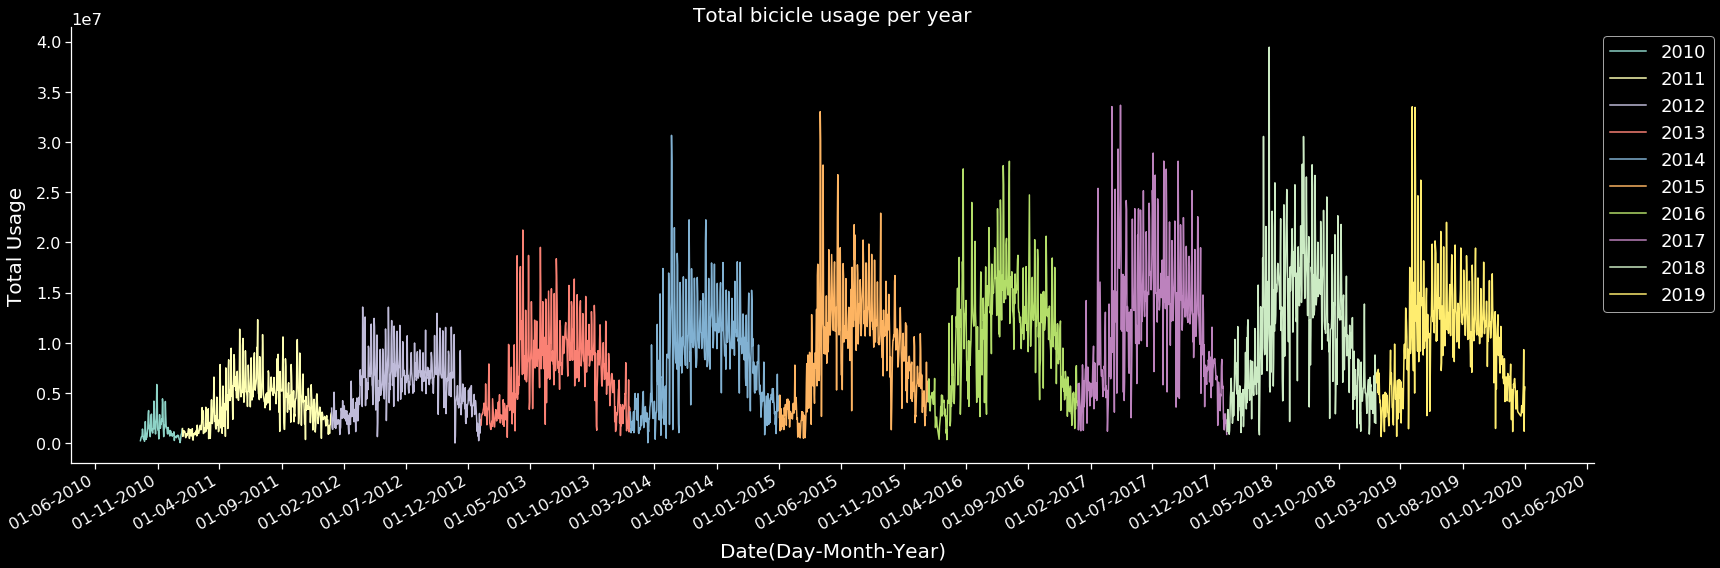

In [526]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Year", height=8, aspect=3)
g=g.map(plt.plot, "Date", "Total usage(s)")
plt.legend(scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Total bicicle usage per year", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Total Usage", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

# plt.savefig("pattern_year.png", dpi=400)

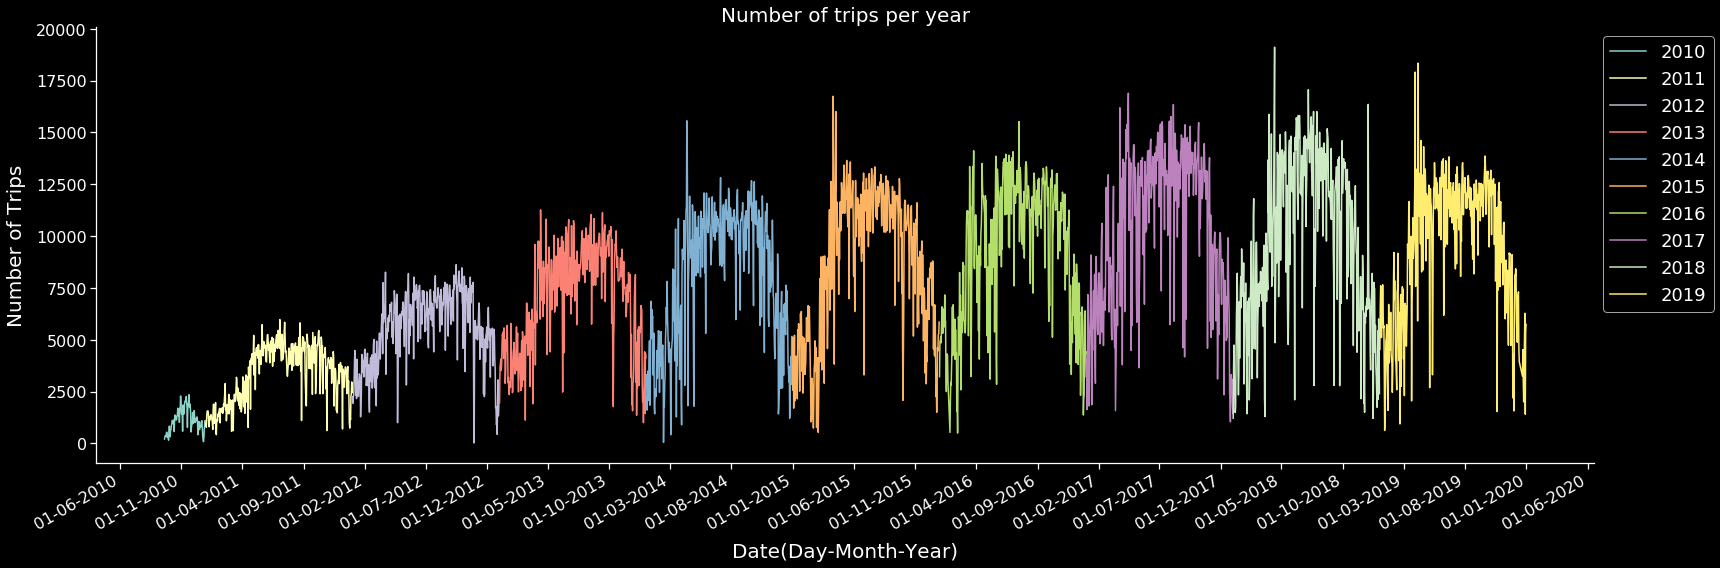

In [527]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Year", height=8, aspect=3)
g=g.map(plt.plot, "Date", "N of trips")
plt.legend(scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Number of trips per year", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Number of Trips", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

In the graph above we can observe a pattern in the bicicle usage yearly consistent with the **weather seasons**. To make this more apparent we can draw a temperature line across. Furthermore, it is clear that during the first 7-8 years the company was growing, but in the last 3 years bicicle usage has stabilized.

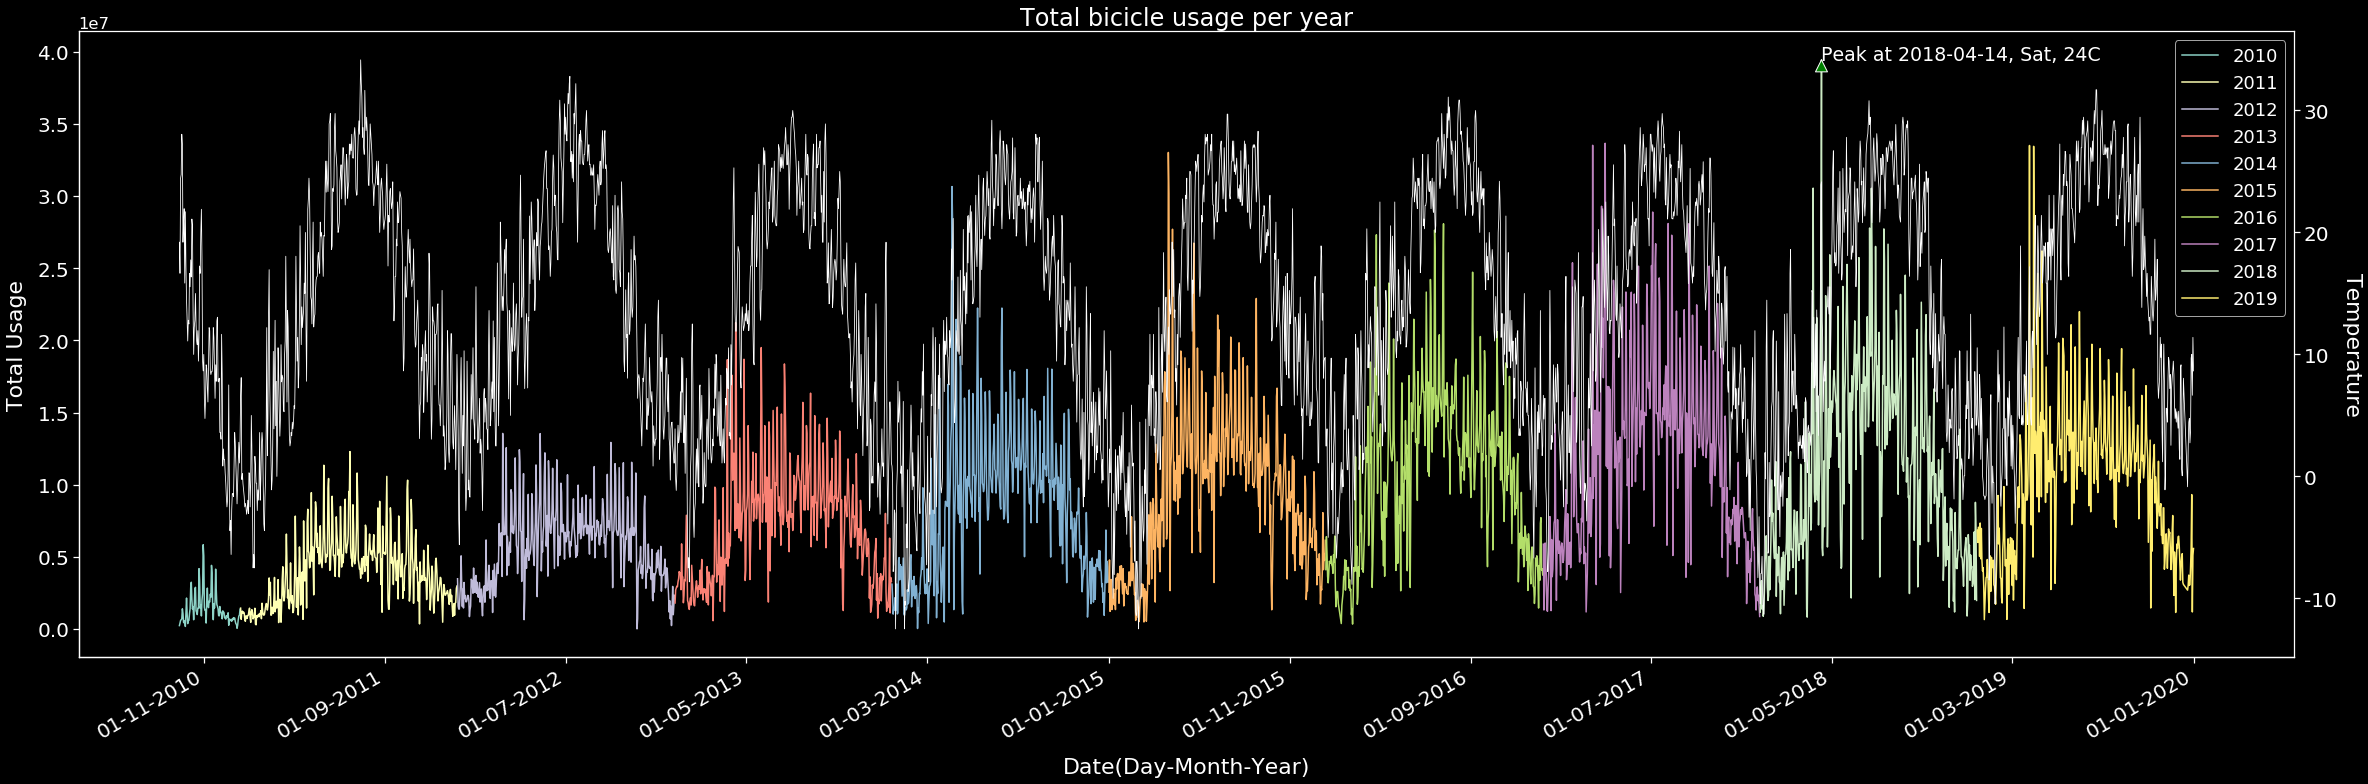

In [528]:
plt.style.use("dark_background")



plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Year", height=11, aspect=3)
g=g.map(plt.plot, "Date", "Total usage(s)")
plt.legend(loc= "best", fontsize=18,  ncol=1)
plt.title("Total bicicle usage per year", fontsize=24)


xmax=df[df["Total usage(s)"] == (df["Total usage(s)"].max())]["Date"]
ymax=df["Total usage(s)"].max()
plt.annotate(s = "Peak at {}, Sat, 24C ".format((str(xmax.values[0])[:10])),xy=(xmax,ymax),xytext=(xmax, ymax+5),  size=19,
           arrowprops=dict(facecolor='green', width=0.02), xycoords="data")

plt.ylabel("Total Usage", labelpad=10, fontsize=22)
plt.xlabel("Date(Day-Month-Year)", labelpad=15, fontsize=22)
plt.xticks(rotation="30", fontsize=20)
plt.yticks(rotation="horizontal", fontsize=20)

ax2 = plt.twinx() 
ax2.plot(df["Date"],df["average Temp"], "w-", linewidth=0.8)
ax2.set_ylabel('Temperature', rotation=270, labelpad=25, fontsize=22)
ax2.set_yticklabels([-20,-10, 0, 10, 20, 30],fontsize=20)

plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=10))


plt.tight_layout()

# plt.savefig("pattern_year_temperature.png", dpi=400)

2.2 Lets also investigate whether if there is a pattern every **month** or **week**

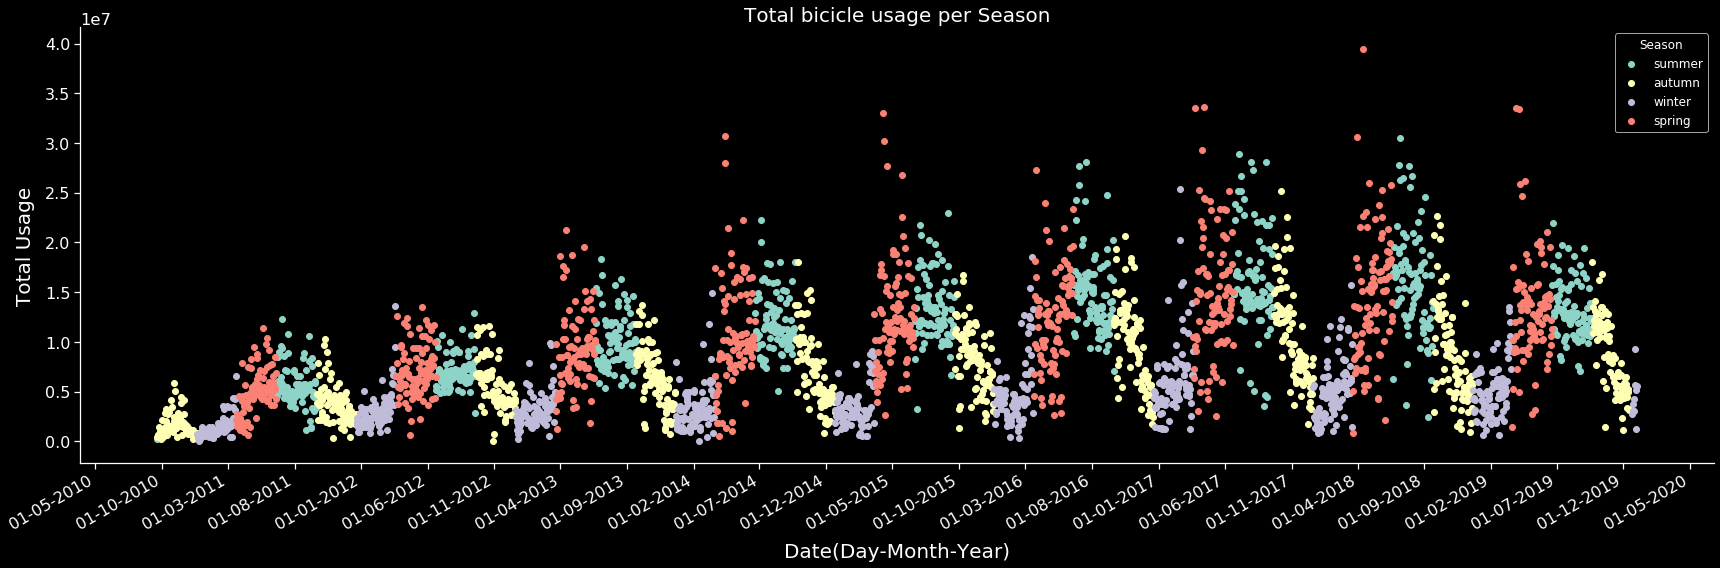

In [529]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Season", height=8, aspect=3)
g=g.map(plt.scatter, "Date", "Total usage(s)")
plt.legend(title="Season", scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=12,  ncol=1)
plt.title("Total bicicle usage per Season", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Total Usage", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

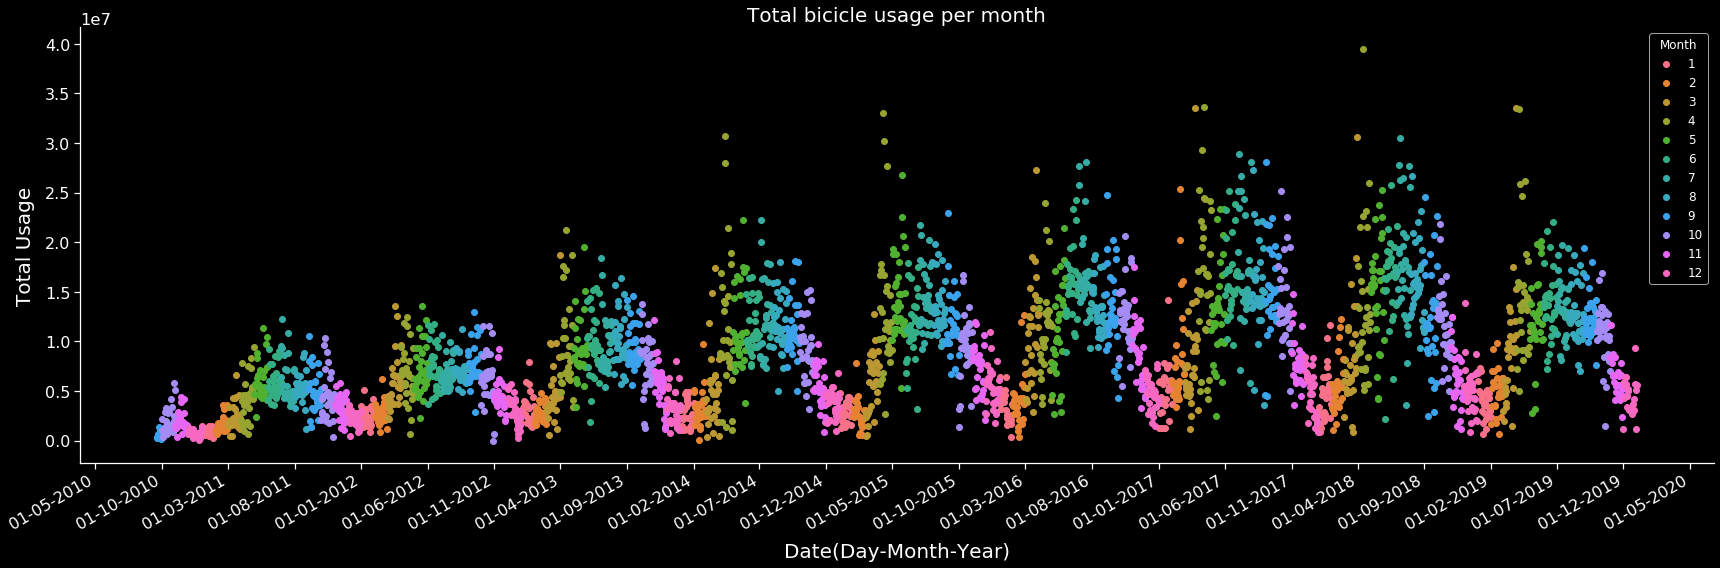

In [530]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Month", height=8, aspect=3)
g=g.map(plt.scatter, "Date", "Total usage(s)")
plt.legend(title="Month", scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=12,  ncol=1)
plt.title("Total bicicle usage per month", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Total Usage", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

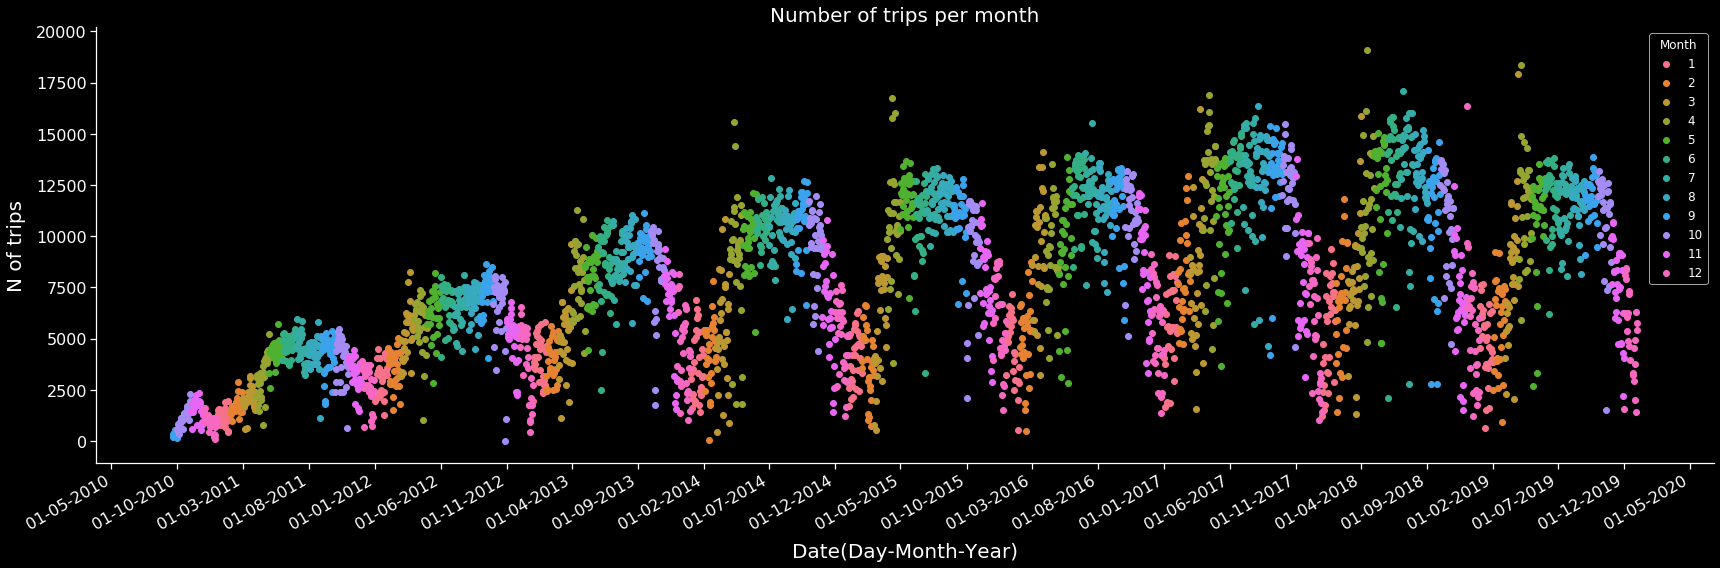

In [531]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Month", height=8, aspect=3)
g=g.map(plt.scatter, "Date", "N of trips")
plt.legend(title="Month", scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=12,  ncol=1)
plt.title("Number of trips per month", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("N of trips", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

2.3 Effect of the **week day** on the bicicle usage

In [532]:
df_weeks = pd.pivot_table(df, index=["Week","Week day"], values = ["Total usage(s)","N of trips"], aggfunc = ["mean"]) # creating a pivot table to plot data averaged from all 10 years

In [533]:
df_weeks.reset_index(inplace=True)

In [534]:
df_weeks.columns = ["Week number", "Week day", "N of trips", "Total usage(s)"]

In [535]:
df_weeks

,Week number,Week day,N of trips,Total usage(s)
0,1,Friday,4237.222222,3.345172e+06
1,1,Monday,3125.100000,2.662908e+06
2,1,Saturday,2955.444444,2.572762e+06
3,1,Sunday,3229.444444,2.902737e+06
4,1,Thursday,4148.888889,3.190192e+06
...,...,...,...,...
366,53,Saturday,4921.000000,6.405129e+06
367,53,Sunday,4965.000000,5.215354e+06
368,53,Thursday,5855.000000,6.153002e+06
369,53,Tuesday,5253.000000,5.210278e+06


In [536]:
def week_day_order(item):
    if item == "Monday":
        return 1
    elif item == "Tuesday":
        return 2
    elif item == "Wednesday":
        return 3
    elif item == "Thursday":
        return 4
    elif item == "Friday":
        return 5
    elif item == "Saturday":
        return 6
    elif item == "Sunday":
        return 7

In [537]:
def num_week_to_season(item):
    if item <=8 or item >= 48:
        return "Winter"
    elif item > 8 and item <= 21:
        return "Spring"
    elif item > 21 and item <= 34:
        return "Summer"
    elif item > 34 and item < 48:
        return "Autumn"

In [538]:
df_weeks["Week day order"] = df_weeks["Week day"].apply(week_day_order) 

In [539]:
df_weeks["Season"] = df_weeks["Week number"].apply(num_week_to_season) 

In [540]:
df_weeks = df_weeks. sort_values(by=["Week number", "Week day order"])

In [541]:
df_weeks

,Week number,Week day,N of trips,Total usage(s),Week day order,Season
1,1,Monday,3125.100000,2.662908e+06,1,Winter
5,1,Tuesday,3770.600000,3.328210e+06,2,Winter
6,1,Wednesday,4337.000000,3.415853e+06,3,Winter
4,1,Thursday,4148.888889,3.190192e+06,4,Winter
0,1,Friday,4237.222222,3.345172e+06,5,Winter
...,...,...,...,...,...,...
370,53,Wednesday,5275.000000,4.755277e+06,3,Winter
368,53,Thursday,5855.000000,6.153002e+06,4,Winter
364,53,Friday,3220.000000,4.119373e+06,5,Winter
366,53,Saturday,4921.000000,6.405129e+06,6,Winter


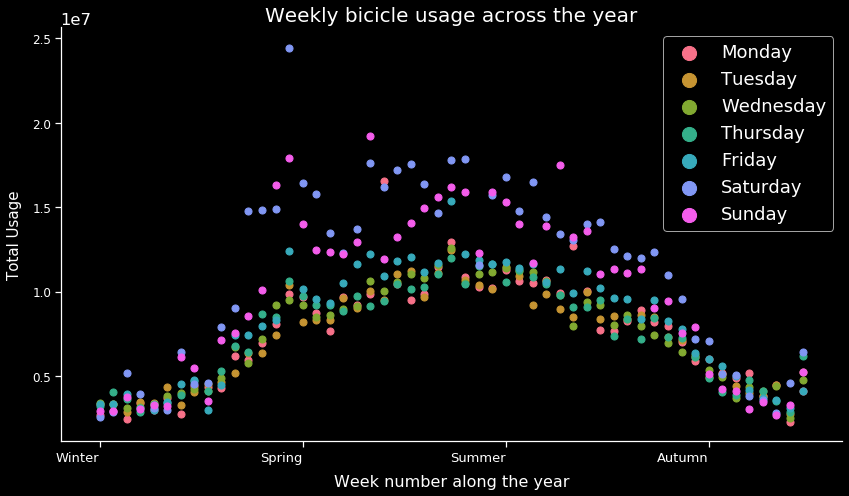

In [542]:
plt.style.use("dark_background")

# color=cm.rainbow(np.linspace(0,1,7))
week_pallete = sns.color_palette("husl", 7)

g=sns.FacetGrid(df_weeks, hue="Week day", height=7, aspect=1.7, palette=week_pallete)




g=g.map(plt.scatter, "Week number", "Total usage(s)", s=50, alpha=1)
plt.legend(markerscale=2, scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Weekly bicicle usage across the year", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Total Usage", labelpad=10, fontsize=15)
plt.xlabel("Week number along the year", labelpad=10, fontsize=16)
plt.xticks(np.arange(1,53, step=15), list(df_weeks["Season"].unique()), rotation=0, fontsize=13)
plt.yticks(rotation="horizontal", fontsize=12)

plt.tight_layout()

We can clearly see that during weekend speople use bike more time specially during the spring and summer seasons

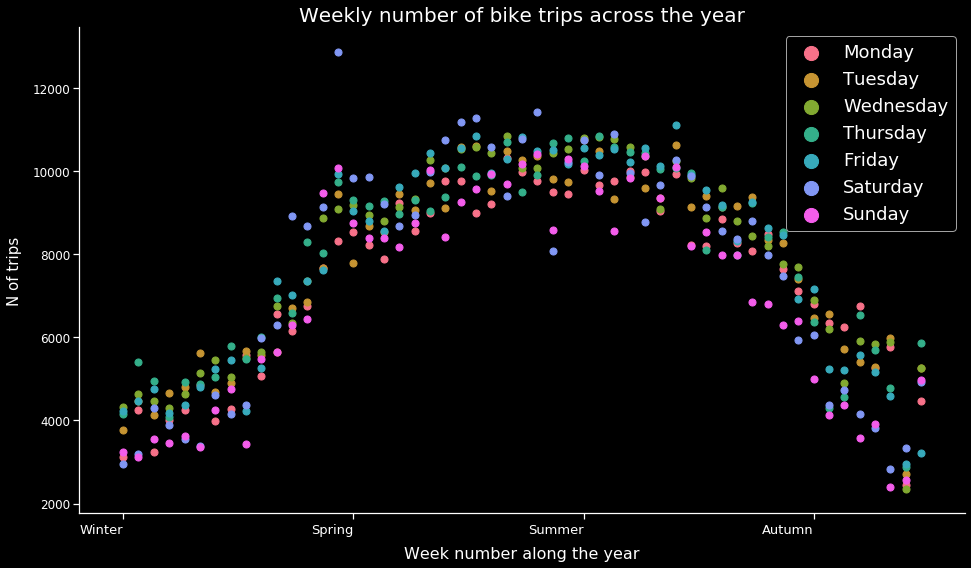

In [543]:
plt.style.use("dark_background")

# color=cm.rainbow(np.linspace(0,1,7))
week_pallete = sns.color_palette("husl", 7)

g=sns.FacetGrid(df_weeks, hue="Week day", height=8, aspect=1.7, palette=week_pallete)




g=g.map(plt.scatter, "Week number", "N of trips", s=50, alpha=1)
plt.legend(markerscale=2, scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Weekly number of bike trips across the year", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("N of trips", labelpad=10, fontsize=15)
plt.xlabel("Week number along the year", labelpad=10, fontsize=16)
plt.xticks(np.arange(1,53, step=15), list(df_weeks["Season"].unique()), rotation=0, fontsize=13)
plt.yticks(rotation="horizontal", fontsize=12)

plt.tight_layout()

In the plot above we again observe that number of trips increase clearly during **spring and summer**, but the differences among week days are not so large as compared to the total trip time. This indicates that on these months people use them longer time regardless of the week day.

2.3 Lets analyze now if temperature, rain and membership have a major effects on the total time per trip and on the total number of trips.

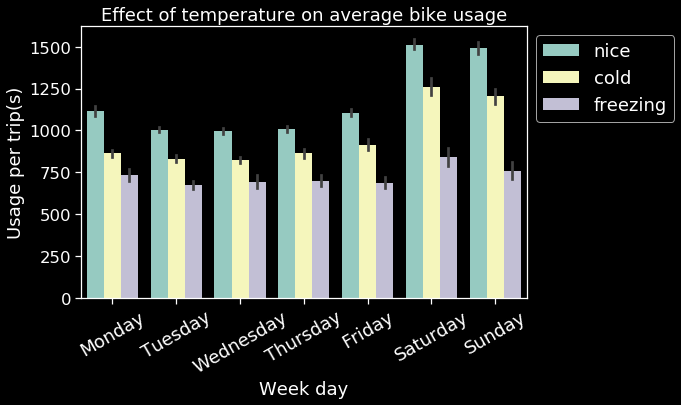

In [544]:
plt.subplots(figsize=(8,5))
plt.title("Effect of temperature on average bike usage")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="Usage per trip(s)", data=df, hue="Temp Level")
plt.legend(bbox_to_anchor=(1.35, 1), loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.savefig("Effect of temperature on bike usage.png", dpi=400)
plt.show()

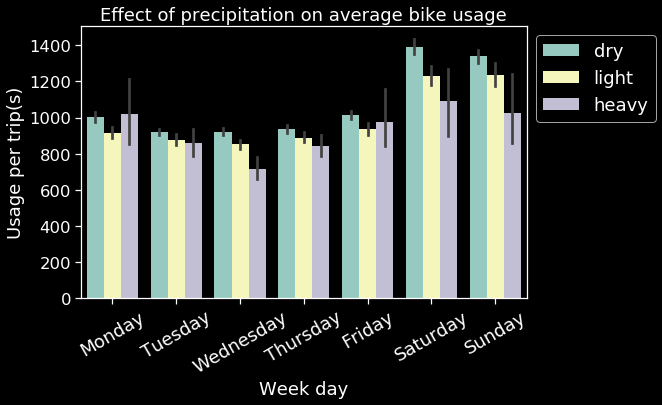

In [545]:
plt.subplots(figsize=(8,5))
plt.title("Effect of precipitation on average bike usage")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="Usage per trip(s)", data=df, hue="Rain Level")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

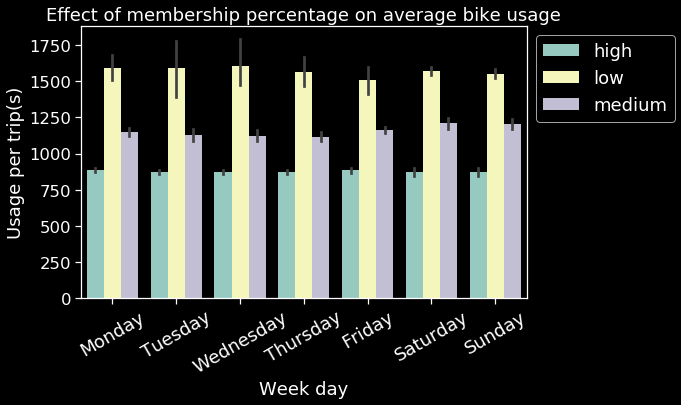

In [546]:
plt.subplots(figsize=(8,5))
plt.title("Effect of membership percentage on average bike usage")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="Usage per trip(s)", data=df, hue="membership")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

From the above plots we observe that temperature seems to be a higher factor compared to rain in the average time per trip. This could be because when it rains people tend to take the bike less(we can actually see this is the case in the plot below). We also see that when its freezing, there is not increase in the average time of usage over the weekend.
Furthermore, we observe that the higher the membership percentage, the lower the ride time.

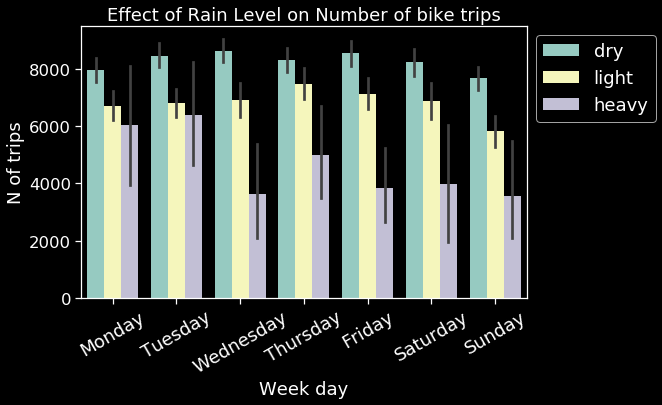

In [547]:
plt.subplots(figsize=(8,5))
plt.title("Effect of Rain Level on Number of bike trips")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="N of trips", data=df, hue="Rain Level")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

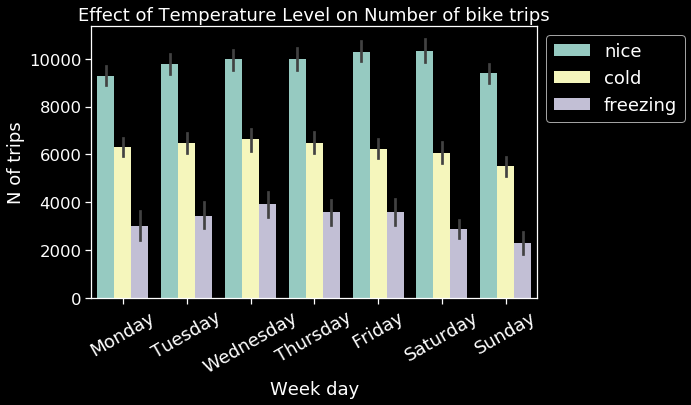

In [548]:
plt.subplots(figsize=(8,5))
plt.title("Effect of Temperature Level on Number of bike trips")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="N of trips", data=df, hue="Temp Level")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

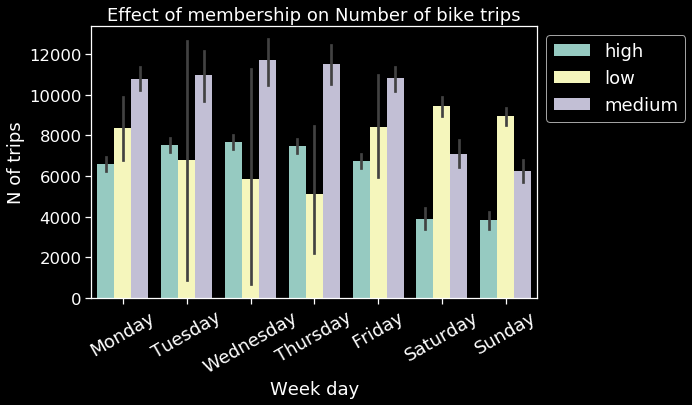

In [549]:
plt.subplots(figsize=(8,5))
plt.title("Effect of membership on Number of bike trips")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="N of trips", data=df, hue="membership")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

2.4 Next, let's investigate the correlation among the attributes paying special attention to the correlation with the total usage and number of trips

In [550]:
df.head()

,Date,Total usage(s),N of trips,Prop members,Usage per trip(s),Week day,prcp,t max,t min,average Temp,...,Holiday/Weekend,Year,Month,Week,Day,membership,Temp Level,Rain Level,Day of year,Season
0,2010-09-20,242253.0,212,0.839623,1143.0,Monday,0.0,25.6,12.8,19.20,...,0,2010,9,38,20,high,nice,dry,263,summer
1,2010-09-21,414304.0,324,0.663580,1279.0,Tuesday,0.0,25.0,8.3,16.65,...,0,2010,9,38,21,low,nice,dry,264,autumn
2,2010-09-22,600602.0,377,0.689655,1593.0,Wednesday,0.0,32.8,16.1,24.45,...,0,2010,9,38,22,low,nice,dry,265,autumn
3,2010-09-23,650596.0,373,0.667560,1744.0,Thursday,0.0,31.7,17.8,24.75,...,0,2010,9,38,23,low,nice,dry,266,autumn
4,2010-09-24,704149.0,362,0.569061,1945.0,Friday,0.0,35.0,21.1,28.05,...,0,2010,9,38,24,low,nice,dry,267,autumn


In [551]:
df_corr = df.iloc[:, [1,2,3,4,6,7,8,9]]

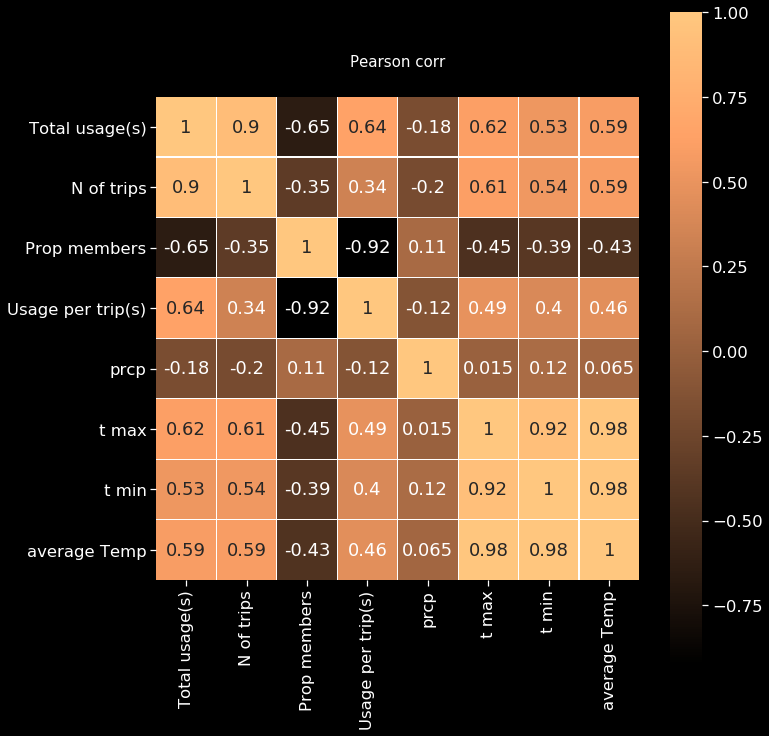

In [552]:
plt.rcParams["figure.figsize"] = (11,11)
colormap=plt.cm.copper
plt.title("Pearson corr", y=1.05, size=15)
sns.heatmap(df_corr.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)
plt.tight_layout()
# plt.savefig("corr.png", dpi=400)
plt.show()

In [553]:
corr_matrix = df_corr.corr()


In [554]:
corr_matrix

,Total usage(s),N of trips,Prop members,Usage per trip(s),prcp,t max,t min,average Temp
Total usage(s),1.000000,0.901450,-0.648636,0.643249,-0.176296,0.615699,0.533950,0.587839
N of trips,0.901450,1.000000,-0.349149,0.337494,-0.196067,0.613120,0.538986,0.588958
Prop members,-0.648636,-0.349149,1.000000,-0.924227,0.105126,-0.451857,-0.388441,-0.429727
Usage per trip(s),0.643249,0.337494,-0.924227,1.000000,-0.119251,0.488142,0.403228,0.456157
prcp,-0.176296,-0.196067,0.105126,-0.119251,1.000000,0.014729,0.116195,0.064984
t max,0.615699,0.613120,-0.451857,0.488142,0.014729,1.000000,0.921772,0.981608
t min,0.533950,0.538986,-0.388441,0.403228,0.116195,0.921772,1.000000,0.978839
average Temp,0.587839,0.588958,-0.429727,0.456157,0.064984,0.981608,0.978839,1.000000


In [555]:
corr_vals = abs(corr_matrix[["Total usage(s)", "N of trips"]]).sort_values(by=["Total usage(s)", "N of trips"], ascending=False)

In [556]:
corr_vals

,Total usage(s),N of trips
Total usage(s),1.000000,0.901450
N of trips,0.901450,1.000000
Prop members,0.648636,0.349149
Usage per trip(s),0.643249,0.337494
t max,0.615699,0.613120
average Temp,0.587839,0.588958
t min,0.533950,0.538986
prcp,0.176296,0.196067


Lets explore the distribution of these variable with a density plot

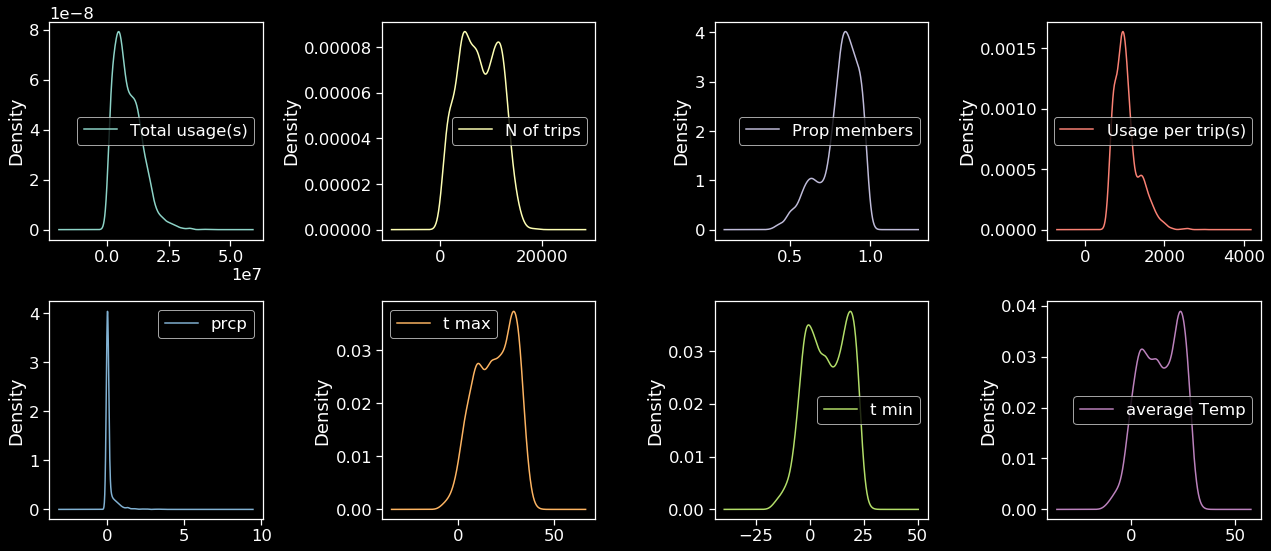

In [557]:
df_corr.plot(kind='density', subplots=True, layout=(2,4), sharex=False,figsize=(18,8))
plt.tight_layout()
#plt.savefig("density numeric attributes.png", dpi=400)

### 3. Prepare df for modeling (Preprocessing)

First we need to choose the attributes for the modeling.
* Numerical
    * Proportion members
    * t max
    * prcp	
* Categorical variables
    * holidays
    * dates: Dates are rich sources of information. We saw that the week day and year-period reflect bicicle usage patterns. 

In [558]:
df.columns

Index(['Date', 'Total usage(s)', 'N of trips', 'Prop members',
       'Usage per trip(s)', 'Week day', 'prcp', 't max', 't min',
       'average Temp', 'Holiday', 'Holiday/Weekend', 'Year', 'Month', 'Week',
       'Day', 'membership', 'Temp Level', 'Rain Level', 'Day of year',
       'Season'],
      dtype='object')

In [559]:
df_model = df[['Total usage(s)', 'N of trips', "Prop members", "prcp", "t max", "Month", "Holiday/Weekend", "Week day"]]

In [560]:
df_model = pd.get_dummies(df_model)

### 4. Data Split

We want that after our split we obtian a balanced distribution of the target values accorss the data. Hence, we first need to see whether if our target **normaly distributed** or **skewed**? We will start predicting the Total Usage. We observe that the data is skewed to the right. Hence, stratifying the data set is adviced for the splitting.

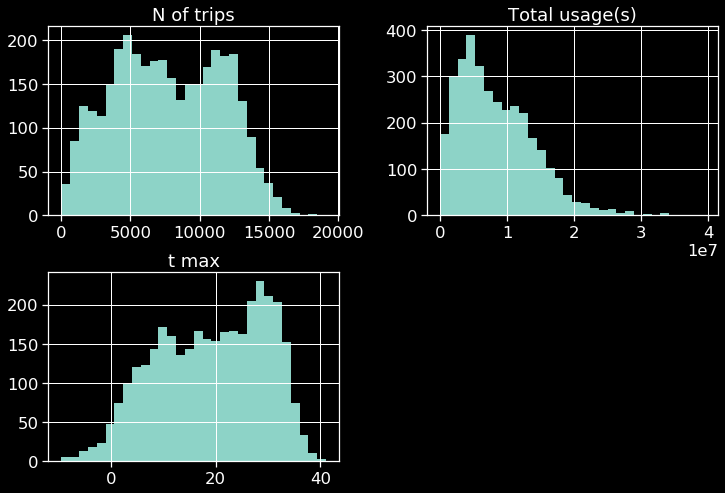

In [561]:
plt.rcParams["figure.figsize"] = (12,8)
df_model[['Total usage(s)', 'N of trips','t max']].hist(bins=30)
plt.show()

Lets stratify the split based on the stratification of t max in 5 different strata.

In [562]:
def strater (col_item):
    if col_item <= 5:
        return 1
    elif col_item > 5 and col_item <= 12:
        return 2
    elif col_item > 12 and col_item <= 23:
        return 3
    elif col_item > 23 and col_item <= 30:
        return 4
    else:
        return 5

In [563]:
df_model["strat"] = df_model["t max"].apply(strater)

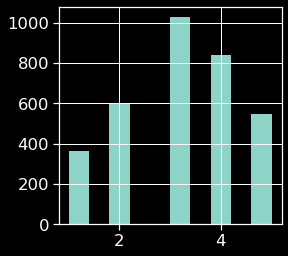

In [564]:
plt.rcParams["figure.figsize"] = (4,4)
df_model["strat"].hist(bins=10)
plt.show()

In [565]:
X = df_model.drop(['Total usage(s)','N of trips'], axis=1)
y = df_model['Total usage(s)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [566]:
test_set = X_test

In [567]:
test_set["strat"] = X_test["t max"].apply(strater)

C:\Users\enriq\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [568]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=10)

In [569]:
for train_index, test_index in split.split(df_model, df_model["strat"]):
    strat_train_set = df_model.loc[train_index]
    strat_test_set = df_model.loc[test_index]

In [570]:
def proportions(data):
    return data["strat"].value_counts()/len(data)

In [571]:
comparing = pd.DataFrame({"Overall": proportions(df_model),
                         "Stratified": proportions(strat_test_set),
                         "Random": proportions(X_test)}).sort_index()

In [572]:
comparing = round(comparing *100,2) 

In [573]:
comparing 
# We can observe how the proportions in the stratified set are closer 
# to those in the whole set compared to the ramdomly generated set

,Overall,Stratified,Random
1,10.80,10.80,10.21
2,17.69,17.60,17.31
3,30.41,30.47,29.44
4,24.88,24.85,25.59
5,16.21,16.27,17.46


In [574]:
strat_train_set.drop("strat", axis=1, inplace=True)
strat_test_set.drop("strat", axis=1, inplace=True)

In [575]:
X_train = strat_train_set.drop(["Total usage(s)","N of trips"], axis=1)
y_train = strat_train_set["Total usage(s)"].values

In [576]:
X_test = strat_test_set.drop(["Total usage(s)","N of trips"], axis=1)
y_test = strat_test_set["Total usage(s)"].values

In [577]:
df_model.drop("strat", axis=1, inplace=True)

### 5. Data standarization

In [578]:
scaler = StandardScaler().fit(X) # Scaling the data
X_rescaled = scaler.transform(X)

In [579]:
df_rescaled=pd.DataFrame(X_rescaled)
df_rescaled.columns = X.columns

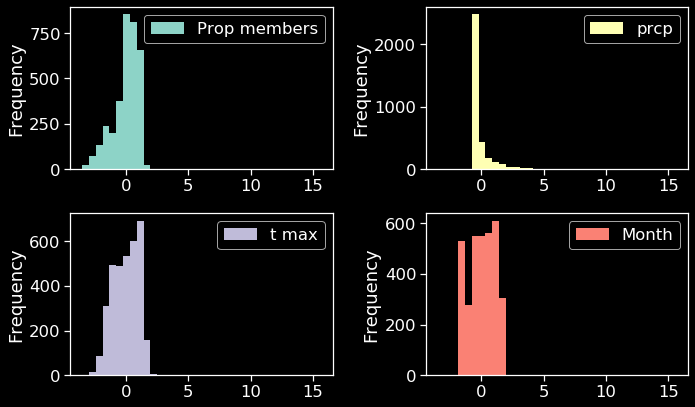

In [580]:
df_rescaled.iloc[:,:4].plot(kind='hist', bins=35, subplots=True, layout=(2,2), sharex=False,figsize=(10,6))
plt.tight_layout()
#plt.savefig("density numeric attributes.png", dpi=400)

In [581]:
X_rescaled.shape

(3380, 13)

Lets use some PCA to observe what are the features driving the variance in our train set

In [593]:
# PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X_rescaled)

In [594]:
sum(pca.explained_variance_ratio_) # Two components are only able to account for 37% of the variance

0.37492998605812977

In [583]:
X_red = pd.DataFrame(X2D)

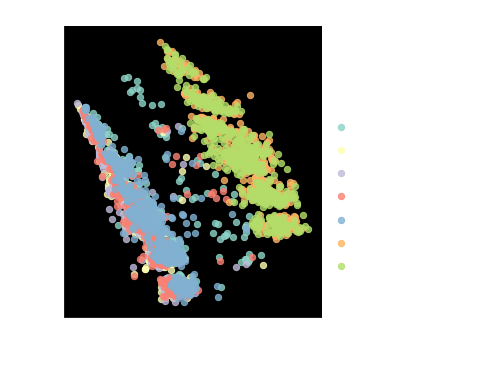

In [631]:
week_day_pca = pd.concat([X_red,pd.DataFrame(df["Week day"], columns=["Week day"])], axis=1)
week_day_pca.columns = ["Component1", "Component2", "Week day"]
grid = sns.FacetGrid(week_day_pca, height=5, hue="Week day")
grid.map(plt.scatter, "Component1", "Component2", s=40, alpha=0.8).add_legend()
plt.title("PCA Week Days")
plt.show()

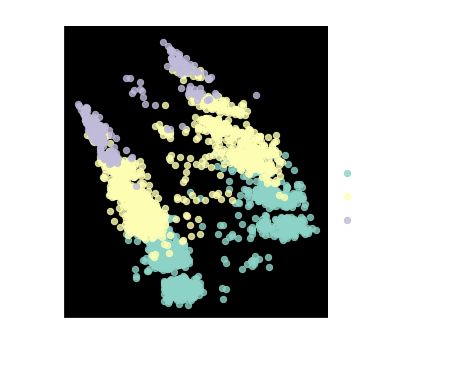

In [635]:
temp_level_pca = pd.concat([X_red,pd.DataFrame(df["Temp Level"], columns=["Temp Level"])], axis=1)
temp_level_pca.columns = ["Component1", "Component2", "Temp Level"]
grid = sns.FacetGrid(temp_level_pca, height=5, hue="Temp Level")
grid.map(plt.scatter, "Component1", "Component2", s=40, alpha=0.8).add_legend()
plt.title("PCA Temperature Level")
# plt.savefig("Temp_level.png", dpi=400)
plt.show()

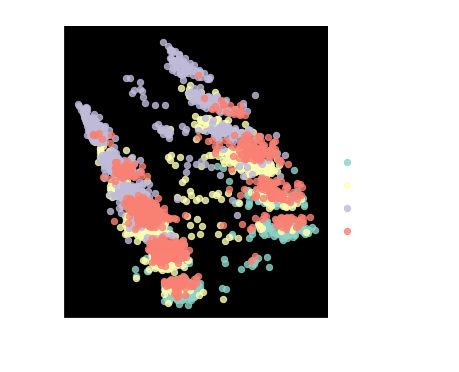

In [632]:
holidays_pca = pd.concat([X_red,pd.DataFrame(df["Season"], columns=["Season"])], axis=1)
holidays_pca.columns = ["Component1", "Component2", "Season"]
grid = sns.FacetGrid(holidays_pca, height=5, hue="Season")
grid.map(plt.scatter, "Component1", "Component2", s=40, alpha=0.8).add_legend()
plt.title("PCA Seasons")
plt.show()

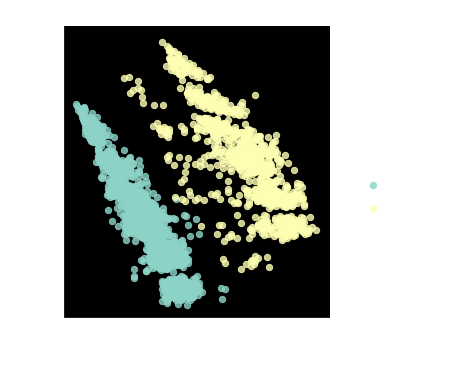

In [634]:
holidays_pca = pd.concat([X_red,pd.DataFrame(df["Holiday/Weekend"], columns=["Holiday/Weekend"])], axis=1)
holidays_pca.columns = ["Component1", "Component2", "Holiday/Weekend"]
grid = sns.FacetGrid(holidays_pca, height=5, hue="Holiday/Weekend")
grid.map(plt.scatter, "Component1", "Component2", s=40, alpha=0.8).add_legend()
plt.title("PCA Holidays")
# plt.savefig("PCA_holidays.png", dpi=400)
plt.show()

We can see that holidays create a clear cluster, making it an important feature contributing to the variance in our data set

Standarize train and test sets:

In [588]:
scaler1= StandardScaler().fit(X_train)
scaler2 = StandardScaler().fit(X_test)

X_train_rescaled = scaler1.transform(X_train)
X_test_rescaled = scaler2.transform(X_test)

### 4. Exploring model performance

In [646]:
# Exploring model performance. Metrics used neg_mean_squared_error using cross-validation

models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso())) 
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor())) 
models.append(('XGB', xgb.XGBRegressor(objective='reg:squarederror')))
models.append(('ETR', ExtraTreesRegressor()))

results_model = []
names_model = []
for name, model in models:
    KF = KFold(n_splits=10, random_state=10)
    cv_results = cross_val_score(model, X_train_rescaled, y_train, cv=KF, scoring='neg_root_mean_squared_error')
    results_model.append(cv_results)
    names_model.append(name)
    msg = "%s: %s (%s)" % (name, round(cv_results.mean(),0), round(cv_results.std(),0))
    print(msg)

LR: -3620927.0 (164937.0)
Lasso: -3620284.0 (166826.0)
EN: -3831760.0 (156277.0)
CART: -4230951.0 (288704.0)
KNN: -3488621.0 (166719.0)
SVR: -5742231.0 (216073.0)
RFR: -3186877.0 (159331.0)
GBR: -3208247.0 (125515.0)
XGB: -3208976.0 (127195.0)
ETR: -3230157.0 (159542.0)


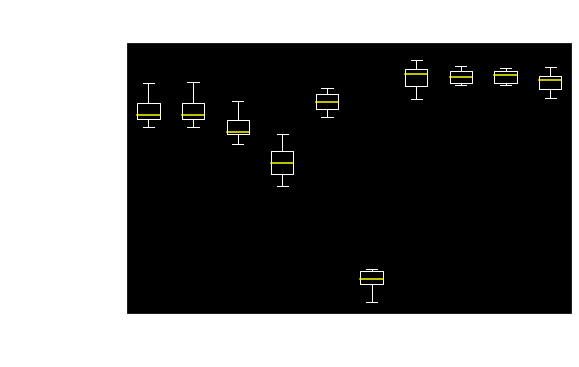

In [647]:
# Compare Algorithms

plt.rcParams["figure.figsize"] = (8,5)
fig = plt.figure()
fig.suptitle('Algorithm Performance Comparison', fontsize=18)
ax = fig.add_subplot(111)

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

plt.boxplot(results_model, boxprops=boxprops,medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, showfliers=True, flierprops=flierprops)
ax.set_xticklabels(names_model, rotation=30)
ax.set_ylabel("RMSE")
# plt.savefig("Algo_comp.png", dpi=400)


plt.show()

The above analysis revealed **Gradient Boosting Regressor(GBR)** as the most promissing model. Lets fine tune it using GridSearchCV

### 5. Fine Tunning and model evaluation

I will try two approaches: GridSearchCV and Early Stopping

In [753]:
# GridSearchCV
n_estimators = [65] # [0, 50, 100, 150, 200]
learning_rate = [0.045] # [0.03, 0.05, 0.3, 1]
max_depth = [1,2,4,8,10]
min_samples_leaf = [1, 5, 11]

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, min_samples_leaf=min_samples_leaf, max_depth=max_depth)


model = GradientBoostingRegressor()
KF = KFold(n_splits=5, random_state=10) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best -3196083.947168 (113704.093752) with: {'learning_rate': 0.045, 'max_depth': 8, 'min_samples_leaf': 11, 'n_estimators': 65}

Best: -3196083.947168 using {'learning_rate': 0.045, 'max_depth': 8, 'min_samples_leaf': 11, 'n_estimators': 65}
-3823291.103129 (116830.077218) with: {'learning_rate': 0.045, 'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 65}
-3823291.103129 (116830.077218) with: {'learning_rate': 0.045, 'max_depth': 1, 'min_samples_leaf': 5, 'n_estimators': 65}
-3823291.103129 (116830.077218) with: {'learning_rate': 0.045, 'max_depth': 1, 'min_samples_leaf': 11, 'n_estimators': 65}
-3471015.223764 (88690.081219) with: {'learning_rate': 0.045, 'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 65}
-3469814.584121 (89256.918924) with: {'learning_rate': 0.045, 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 65}
-3472331.082719 (85678.638184) with: {'learning_rate': 0.045, 'max_depth': 2, 'min_samples_leaf': 11, 'n_estimators': 65}
-3285065.891572 (112428.159275) with: {'learning_rate': 0.045, 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 65}
-3288821.566566 (113523.034874) wi

In [757]:
GBoost = GradientBoostingRegressor(learning_rate=0.045, n_estimators=65, max_depth=4, min_samples_leaf=5) # adjusting parameters to avoid overfitting
GBoost.fit(X_train_rescaled,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.045, loss='ls',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=65,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [758]:
GBoost.score(X_train_rescaled,y_train)

0.7256289595044142

In [759]:
GBoost.score(X_test_rescaled,y_test)

0.6376220011121878

### 6. Productionazing the model

In [763]:
X = X.drop("strat", axis=1)

In [764]:
X

,Prop members,prcp,t max,Month,Holiday/Weekend,Week day_Friday,Week day_Monday,Week day_Saturday,Week day_Sunday,Week day_Thursday,Week day_Tuesday,Week day_Wednesday
0,0.839623,0.00,25.6,9,0,0,1,0,0,0,0,0
1,0.663580,0.00,25.0,9,0,0,0,0,0,0,1,0
2,0.689655,0.00,32.8,9,0,0,0,0,0,0,0,1
3,0.667560,0.00,31.7,9,0,0,0,0,0,1,0,0
4,0.569061,0.00,35.0,9,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3375,0.808991,0.00,14.4,12,0,1,0,0,0,0,0,0
3376,0.724292,0.00,18.3,12,1,0,0,1,0,0,0,0
3377,0.850248,0.59,8.9,12,1,0,0,0,1,0,0,0
3378,0.866396,0.24,16.7,12,0,0,1,0,0,0,0,0


In [ ]:
# Lets write a predict function

def predict_price(location, sq_mt_built, n_bathrooms, n_rooms):
    loc_index = np.where(X.columns==location)[0][0] # X is an np array so we use where method to loc the index
    
    x= np.zeros(len(X.columns))
    x[0] = sq_mt_built
    x[1] = n_rooms
    x[2] = n_bathrooms
    if loc_index >= 0:
        x[loc_index] = 1
    print(x)
        
    return rfr.predict([x])[0]   
    